# Easy 21: A practical Introduction to Reinforcement Learning

This resource is intended to help people getting started with Reinforcement Learning (RL) in a practical way.

We'll implement the task Easy21 proposed at the [Reinforcement Learning (RL) course by David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html). The task is described in details [here](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf).

---
  * Credit for the code that plots and generate the gifs of the value functions goes to [AnalogRL implementation's of easy21](https://github.com/analog-rl/Easy21).

## Prerequisites

* Be familiar with Python.
* You've watched some/most of the videos from the [Reinforcement Learning (RL) course by David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html)


> Suggestions? Something's wrong or could be better? Feel free to open an issue or to make a PR!

## Summary

    1. Introduction to RL concepts
    2. Learn as you go: solving the Easy21 assigment
       2.1 Implementing the Environment
       2.2 Monte Carlo Policy Evaluation
       2.3 Monte Carlo Policy Control
       2.4 Sarsa lambda Policy Control
       2.5 Linear Function approximation
    3. What's next?

## 1. Introduction to Reinforcement Learning (RL)

### Problem definition

Reinforcement Learning is a subfield of Machine Learning that is concerned with finding the optimal way to make decisions. In order words, given the context and the information what is the best decision I can make in order to have better results.

Imagine that we're playing chess, given the state of the board what is the optimial move you should make in order to increase your changes of winning the game? That's what RL is about, not just for chess but any decision making involving task.

In a resume, we assume there's an **agent** on an **environment**. The agent sees an observation (**state**) of the environment, the agent can choose an **action** based on this observation and may or may not receive a **reward** (scalar feedback signal).

Based on the observations and rewards the agent should choose an action to perform. This action will affect the environment resulting in a new state and maybe a reward.


![](https://miro.medium.com/max/717/1*HvoLc50Dpq1ESKuejhICHg.png)
*Image from: https://medium.com/machine-learning-for-humans/reinforcement-learning-6eacf258b265*

**We want to find which actions (decisions) we should make in a way to maximise the total future reward.**

### Concepts

Here are some RL concepts that we need to know to implement the assignement:

#### Learning

In order to learn how to make decisions a RL agent may include:
    
  * **Policy**: agent's behaviour function. Given an state the policy outputs which action the
      agent should take. Policy(state) -> action.

  * **Value function**: the expected future reward at a given state.  
      There are two types of value functions:
      * State based value function: **V(`s`)** -> how good is to be at state `s`?
      * State/Action based value function: **Q(`s`, `a`)** -> given that we are at state `s` how good is to perform action `a`?
      
      Both functions consider that the agent is behaving accordingly to some Policy `p`.

  * **Model**: an agent's own representation of the environment. This involves defining or learning transitions
    (s1, a1) -> s2 and rewards.

Two other important concepts are:

* **Return**: usually represented as **G**. The return at a given time is the sum of all rewards from that time on times a discount factor:

```
Gt = sum((discount_factor ** i) * r for i, r in enumerate(rewards[t:]))
```

*Why use a discount factor?* Two reasons are: avoid infinite sums and model that immediate rewards are more relevant than rewards in the far future.

We can now define the value function of a given state as the expected return from that state on.

* **Episode**: sequence of states, actions and rewards (s1, a1, r1, ..., sn, an, rn) generated
  by exploring the environment.
  
---


### How to solve the problem?

We actually have two problems:

 1. How to evaluate a policy? In other words, given a policy how to obtain the value function? With this information we can compare policies (A policy **A** is better than a policy **B** if the value function for all states in A are greater than the value function in B) and hopefully find a optimal policy.
 
 
 2. How can we find the best possible policy? **This solves the problem!!!**

There are some different algorithms to find these answers, in this exercise we'll study and implement some of them.

If you're familiar with machine learning tasks (such as classification, regression, ...) one thing you may have noticed is that RL is very different than ML:

  * no supervisor, we'll use the reward signal to learn;
  * feedback is not instantaneous and some times very sparse, what if we don't get a reward for a long time?;
  * time matters, we're dealing with sequential data;
  * an agent's actions affect the next data it receives (non-iid data).

You may have a lot of questions as we go, this is expected given the amount of new concepts, if you want to learn more and hopefully get answers check the last section **3. Next steps** where you'll find more detailed resourcers and full courses.

## 2. Learn as you go: solving the Easy21 assigment

 You can check the detailed rules of the Easy 21 game [here](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf).

**Summarized rules of Easy21**:

* The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
* Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3)
* There are no aces or picture (face) cards in this game
* At the start of the game both the player and the dealer draw one black card in a fully observed fashion (aka they know each other first drawn cards)
* Each turn the player may either stick or hit
* If the player hits then she draws another card from the deck
* If the player sticks she receives no further cards
* The values of the player’s cards are added (black cards) or subtracted (red cards)
* If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward = -1)
* If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins (reward = 1); otherwise, the outcome – win (reward = +1), lose (reward = -1), or draw (reward = 0) – is the player with the largest sum.

### Before get started: Dependencies + code used for plots

**Dependencies**

First let's import the python libraries needed to run all the code present in this notebook.

In [1]:
'''
Copyright [2017] [Marianne Linhares Monteiro, github: @mari-linhares]

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''
# for vectors manipulation
import numpy as np

# for plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# visualize plots in the jupyter notebook
# check more https://goo.gl/U3Ai8R
%matplotlib inline

# for generating random values
import random

# for representing things like card value or colors
from enum import Enum  

# for copying python objects
import copy

**Plot code**

The code below is used to generate the different plots you'll se in the following sections. This code probably does not make a lot of sense at this point, so feel free to skip this code cell and come back to it later if you like.

In [2]:
def plot_value_function(agent, title='Value Function', generate_gif=False, train_steps=None):
    """
    Plots a value function as a surface plot, like in: https://goo.gl/aF2doj

    You can choose between just plotting the graph for the value function
    which is the default behaviour (generate_gif=False) or to train the agent
    a couple of times and save the frames in a gif as you train.

    Args:
        agent: An agent.
        title (string): Plot title.
        generate_gif (boolean): If want to save plots as a gif.
        train_steps: If is not None and generate_gif = True, then will use this
                     value as the number of steps to train the model at each frame.
    """
    # you can change this values to change the size of the graph
    fig = plt.figure(title, figsize=(10, 5))
    
    # explanation about this line: https://goo.gl/LH5E7i
    ax = fig.add_subplot(111, projection='3d')
    
    V = agent.get_value_function()
    
    if generate_gif:
        print('gif will be saved as %s' % title)
    
    def plot_frame(ax):
        # min value allowed accordingly with the documentation is 1
        # we're getting the max value from V dimensions
        min_x = 1
        max_x = V.shape[0]
        min_y = 1
        max_y = V.shape[1]

        # creates a sequence from min to max
        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)

        # creates a grid representation of x_range and y_range
        X, Y = np.meshgrid(x_range, y_range)

        # get value function for X and Y values
        def get_stat_val(x, y):
            return V[x, y]
        Z = get_stat_val(X, Y)

        # creates a surface to be ploted
        # check documentation for details: https://goo.gl/etEhPP
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Value')
        return ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                               linewidth=0, antialiased=False)

    def animate(frame):
        # clear the plot and create a new surface
        ax.clear()
        surf = plot_frame(ax)
        # if we're going to generate a gif we need to train a couple of times
        if generate_gif:
            i = agent.iterations
            # cool math to increase number of steps as we go
            if train_steps is None:
                step_size = int(min(max(1, agent.iterations), 2 ** 16))
            else:
                step_size = train_steps

            agent.train(step_size)
            plt.title('%s MC score: %s frame: %s' % (title, float(agent.wins)/agent.iterations*100, frame))
        else:
            plt.title(title)

        fig.canvas.draw()
        return surf

    ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

    # requires gif writer
    if generate_gif:
        ani.save(title + '.gif', writer='imagemagick', fps=3)
    else:
        plt.show()

def plot_error_vs_episode(sqrt_error, lambdas, train_steps=1000000, eval_steps=1000,
                          title='SQRT error VS episode number', save_as_file=False):
    """
    Given the sqrt error between sarsa(lambda) for multiple lambdas and
    an already trained MC control model this function plots a
    graph: sqrt error VS episode number.

    Args:
        sqrt_error (tensor): Multi dimension tensor.
        lambdas (tensor): 1D tensor.
        train_steps (int): The total steps used to train the models.
        eval_steps (int): Train_steps/eval_steps is the number of time the
                          errors were calculated while training.
        save_as_file (boolean).
    """
    # avoid zero division
    assert eval_steps != 0
    x_range = np.arange(0, train_steps, eval_steps)
    
    # assert that the inputs are correct
    assert len(sqrt_error) == len(lambdas)
    for e in sqrt_error:
        assert len(list(x_range)) == len(e)
    
    # create plot
    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)

    for i in range(len(sqrt_error)-1, -1, -1):
        ax.plot(x_range, sqrt_error[i], label='lambda %.2f' % lambdas[i])
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_as_file:
        plt.savefig(title)
    plt.show()

def plot_error_vs_lambda(sqrt_error, lambdas, title='SQRT error vs lambda', save_as_file=False):
    """
        Given the sqrt error between sarsa(lambda) for multiple lambdas and
        an already trainedMC Control ths function plots a graph:
        sqrt error VS lambda.
        
        Args:
            sqrt_error (tensor): multiD tensor.
            lambdas (tensor): 1D tensor.
            title (string): Plot title.
            save_as_file (boolean).
        
        The srt_error 1D length must be equal to the lambdas length.
    """
    
    # assert input is correct
    assert len(sqrt_error) == len(lambdas)
 
    # create plot
    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)
    
    # Y are the last values found at sqrt_error
    y = [s[-1] for s in sqrt_error]
    ax.plot(lambdas, y)
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_as_file:
        plt.savefig(title)
    plt.show()

### 2.1 Implementing the Environment


    You should write an environment that implements the game Easy21.  

    Specifically, write a function, named step, which takes as input a state *s* (dealer’s first card 1–10 and the player’s sum 1–21), and an action *a* (hit or stick), and returns a sample of the next state *s* (which may be terminal if the game is finished) and a reward *r*.  
        
    We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the transition matrix for the MDP. You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state. - Original assigment

#### Deck

* The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
* Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3)
* There are no aces or picture (face) cards in this game

In [3]:
class Color(Enum):
    RED = 0
    BLACK = 1


class Card(object):
    def __init__(self, color=None):
        self.value = self._get_random_value()
        if color == Color.BLACK or color == Color.RED:
            self.color = color
        else:
            self.color = self._get_random_color()

    def _get_random_value(self):
        """Generates integers between 1 and 10."""
        return random.randint(1, 10)
    
    def _get_random_color(self):
        """Generates random colors.
        
        Color.RED with 1/3 and Color.BLACK with 2/3 probability.
        """
        random_number = random.random()
        if random_number <= 1/3.0:
            return Color.RED
        else:
            return Color.BLACK


class Deck(object):
    def take_card(self, color=None):
        return Card(color)

#### State (observation) and Action

The state is defined by the dealer sum (which I called *dealer_sum*, this information is not available to the player) and the agent cards (which I called *agent_sum*).

In [4]:
class State(object):
    def __init__(self, dealer_sum=0, agent_sum=0, is_terminal=False):
        self.dealer_sum = dealer_sum
        self.agent_sum = agent_sum
        self.is_terminal = is_terminal


class Action(Enum):
    STICK = 0
    HIT = 1

#### Dealer

* If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

The instructions above describe the dealer's policy, let's implement it.

In [5]:
class Player(object):
    """This is a general class for a player of Easy21."""
    def policy(self, s):
        """Given the current state choose the next action."""
        raise NotImplemented()


class Dealer(Player):
    def policy(self, s):
        """Dealers policy as described in the assigment."""
        if s.dealer_sum >= 17:
            return Action.STICK
        else:
            return Action.HIT

#### Environment (Game)

* At the start of the game both the player and the dealer draw one black card (fully observed)
* Each turn the player may either stick or hit
* If the player hits then she draws another card from the deck
* If the player sticks she receives no further cards
* The values of the player’s cards are added (black cards) or subtracted (red cards)
* If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)


In [6]:
class Environment(object):
    """An environment for the game Easy21."""
    def __init__(self):
        # the environment includes the dealer and the deck
        self.dealer = Dealer()
        self.deck = Deck()
        
        self.agent_max_value = 21  # max value an agent can get during the game
        self.dealer_max_value = 10  # max value the dealer can get when taking the first card
        self.actions_count = 2  # number of possible actions
    
    def check_bust(self, player_sum):
        return player_sum < 1 or player_sum > 21
    
    def generate_reward_bust(self, s):
        if s.agent_sum > s.dealer_sum:
            return 1
        elif s.agent_sum == s.dealer_sum:
            return 0
        else:
            return -1

    def take_card(self, card_color=None):
        """Returns a card from the deck."""
        Card = self.deck.take_card(card_color)
        return Card.value if Card.color == Color.BLACK else Card.value * -1

    def dealer_turn(self, s):
        """A full implementation of the dealer turn.
        
           The dealer turn starts when the agent sticks and
           ends when the dealer action is busted or action = sticks.
        """
        action = None
        while not s.is_terminal and action != Action.STICK:
            action = self.dealer.policy(s)
            if action == Action.HIT:
                s.dealer_sum += self.take_card() 
            s.is_terminal = self.check_bust(s.dealer_sum)
        return s
    
    def initial_state(self):
        """In the beginning both the agent and the dealer take a card."""
        return State(self.take_card(Color.BLACK), self.take_card(Color.BLACK))

    def step(self, s, a):
        """
            Given a state and an action return the next state.
            
            Args:
                s (State): Current state.
                a (Action): Action chosen by player.
            return:
                next_s (State): Next state
                r (Integer): Reward (-1, 0, 1).
        """
        # initially there's no reward and the next_s is equal to the
        # current state
        r = 0
        next_s = copy.copy(s)

        # if the player sticks then it's dealer turn
        if a == Action.STICK:
            next_s = self.dealer_turn(s)
            if next_s.is_terminal:
                r = 1
            else:
                next_s.is_terminal = True
                r = self.generate_reward_bust(next_s)       
        else:
            next_s.agent_sum += self.take_card(self.deck)
            next_s.is_terminal = self.check_bust(next_s.agent_sum)

            # if end of the game then player lost: reward = -1
            if next_s.is_terminal:
                r = -1
        
        return next_s, r

Let's create an instance of the environment that the agent can interact with by calling the function **step(s, a)**.

In [7]:
environment = Environment()

### 2.2 Monte Carlo Policy Evaluation (MCPE)

Although the Easy21 exercise doesn't ask for the MCPE implementention, this will give us a base to start working on the following algorithms. MCPE algorithm answers the question *"How to evaluate a policy?"*, in other words how to estimate the value function. This problem is called **prediction**.

Monte Carlo Policy Evaluation (MCPE):

* works only for "episodic" scenariums. It learns from episodes and all episodes must terminate.
* estimates the value function of a policy X from episodes of experience following policy X.
* is model-free: no knowledge of MDP transitions / rewards.
* uses the simplest possible idea: value = mean return.

The MCPE pseudo-code is:
```
for a big number of steps:
    Run one episode and store the states you've visited and the rewards you got.
    for every time-step t:
        Increment counter: N(s) ← N(s) + 1
        Increment total return: G_s(s) ← G_s(s) + Gt
        Value is estimated by mean return V(s) = G_s(s)/N(s)

The value function will get close to the real value function as N(s) → ∞
```

*Okay...we know how to evaluate a policy but what policy will be used?*
Let's use a very simple policy, the same policy of the dealer! if the sum of the agent's cards is > 17
we stick otherwise we hit.

Let's implement this!


**General Agent**

Before going into details about Monte Carlo Policy Evaluation, let's implement a General class Agent, this will help us reuse a lot of code and better understand the agent's interface.

In [8]:
class Agent(Player):  
    def __init__(self, environment, No=100, discount_factor=1):   
        # Player is a superclass, which means an agent implements a policy
        Player.__init__(self)
        
        # easy21 environment
        self.env = environment
        
        # we can tune these parameters
        # don't worry about this for now
        self.No = No
        self.disc_factor = discount_factor
        
        # V(s) is the state value function. How good is to be at state s?
        # initially we don't know
        self.V = np.zeros([self.env.dealer_max_value + 1, self.env.agent_max_value + 1])
        
        # this will be used to we keep track of the agent's score
        # score is a simple metric to check if the agent is getting better over time
        # score = (# of wins)/(# of games played)
        self.wins = 0.0
        self.iterations = 0.0
  
    def get_clear_tensor(self):
        """This is just a helper function. Not important.

        Returns a tensor with zeros with the correct given shape for Q.
        By default this is (max possible dealer sum, max possible agent sum, number of actions)
        """
        return np.zeros((self.env.dealer_max_value + 1,
                         self.env.agent_max_value + 1, 
                         self.env.actions_count))
 
    def choose_random_action(self):
        """We try to find the best policy possible but we act randomly sometimes."""
        return Action.HIT if random.random() <= 0.5 else Action.STICK

    def choose_best_action(self, s):
        """Returns the best action possible in state s."""
        raise NotImplemented()
    
    def get_max_action(self, s):
        """Returns the maxQ(s, a) between all actions."""
        return 0.0

    def get_value_function(self):
        """Get best value function in the moment."""
        for i in range(1, self.env.dealer_max_value + 1):
            for j in range(1, self.env.agent_max_value + 1):
                s = State(i, j)
                self.V[i][j] = self.get_max_action(s)
        return self.V

    def train(self, steps):
        """Train an agent for a certain number of steps.
        
           Args:
               steps (int): number of episodes to run.
           Returns:
               value function.
        """
        for e in range(steps):
            # do something...
            pass
        return self.get_value_function()

**Monte Carlo Evaluation**

In [9]:
class MCAgentEvaluation(Agent):
    
    def __init__(self, environment, No=100, discount_factor=1):
        Agent.__init__(self, environment, No, discount_factor)

        # N(s) is the number of times that state s has been visited
        # N(s, a) is the number of times that action a has been selected from state s.
        self.N = self.get_clear_tensor()
        
        # G_s(s) is the sum of all returns we got using this state
        self.G_s = np.zeros([self.env.dealer_max_value + 1, self.env.agent_max_value + 1])
  
    def get_value_function(self):
        return self.V
    
    def predict(self, episode):
        """Given an episode. Improve the value function approximation."""
        j = 0
        for s, a, _ in episode:
            d_sum = s.dealer_sum
            a_sum = s.agent_sum
            Gt = sum([x[2] * (self.disc_factor ** i) for i, x in enumerate(episode[j:])])
            self.G_s[d_sum][a_sum] += Gt
            self.V[d_sum][a_sum] = self.G_s[d_sum][a_sum] / sum(self.N[s.dealer_sum, s.agent_sum, :])
            j += 1
    
    def policy(self, s):
        """Lets act like the dealer."""
        if s.agent_sum >= 17:
            action = Action.STICK
        else:
            action = Action.HIT
        
        self.N[s.dealer_sum][s.agent_sum][action.value] += 1
        return action
    
    def train(self, steps):
        for e in range(steps):
            episode = []
            
            # get initial state for current episode
            s = self.env.initial_state()
            
            while not s.is_terminal:
                
                # get action with epsilon greedy policy
                a = self.policy(s)
                
                # execute action
                next_s, r = self.env.step(copy.copy(s), a)
                
                # store action state and reward
                episode.append((s, a, r))
                
                # update state
                s = next_s

            self.iterations += 1
            if e % 10000 == 0 and e != 0:
                print("Episode: %d" % e)
                
            # Update value function accordingly
            self.predict(episode) 

        return self.get_value_function()

**Evaluating the policy**

Episode: 10000
Episode: 20000
Episode: 30000
Episode: 40000
Episode: 50000
Episode: 60000
Episode: 70000
Episode: 80000
Episode: 90000


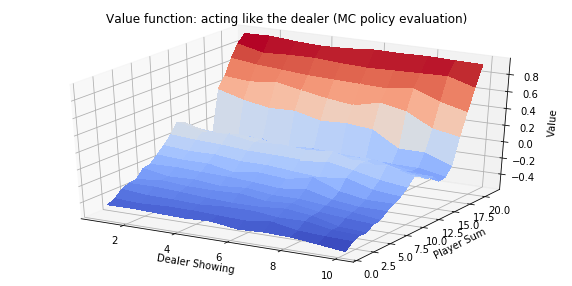

In [10]:
agent_eval = MCAgentEvaluation(environment)
agent_eval.train(100000)

plot_value_function(agent_eval, title='Value function: acting like the dealer (MC policy evaluation)')

This graph is the plot of the value function for every possible state (dealer's first card or player sum) we can be at. What it says is that is very good to have a big sum and act accordingly to this policy, but if you have a small sum is not so good.

High value function (red) -> good state, Low value function (blue) -> bad state.

**Generating a gif of the evaluation over time**

In [11]:
# uncoment these lines to generate the gif you see below
# agent_eval = MCAgentEvaluation(environment)
# plot_value_function(agent_eval, title='Value function: acting like the dealer (MC policy evaluation)',
#                    generate_gif=True, train_steps=1000)

![](imgs/mcpe.gif)

### 2.3 Monte Carlo Policy Control (MCPC)

All the following algorithms we'll implement try to answer the question: *"How can we get to the best possible policy?"*

Since we want the best policy we need to explore other possibilities every once in a while other than the best we know. This is actually the well know dilemma in RL: [exploration vs explotation dilemma](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/XX.pdf).

For this we'll use the e-greedy exploration which is one of the simplest ideas to ensure continual exploration and is defined by:

```
policy(a | st) = { probability 1 - e to choose the greedy action (the best we know, maxQ(st, a)),
                   probability e choose random action
                 }

```

We have our policy, let's check the pseudo-code for the MCPC. We improve our value function by sampling episodes and exploring the environment.

```
for a big number of steps:
    Run one episode and store the states you've visited and the rewards you got.
    for every time-step t:
        Increment counter: N(St) ← N(St) + 1
        error ← (Gt − Q(St, At))
        Q(St, At) ← Q(St, At) + αt * error
```

For this exercise:

* e-greedy exploration strategy with e = N0/(N0 + N(st)), where N0 = 100 is a hyper-parameter, N(s) is the number of times that state s has been visited, and N(st) is the number of times that the state s has been visited.
* Initialise the value function to zero.
* Use a time-varying scalar step-size of αt = 1/N(st, at).

In [12]:
class MCAgentControl(Agent):
    
    def __init__(self, environment, No=100, discount_factor=1):
        Agent.__init__(self, environment, No, discount_factor)
        
        # Q(s, a) is the value function. How good is to choose action a being at state s?
        self.Q = self.get_clear_tensor()
        
        # N(s) is the number of times that state s has been visited
        # N(s, a) is the number of times that action a has been selected from state s.
        self.N = self.get_clear_tensor()
        
    def get_alpha(self, s, a):
        """αt = 1/N(st, at)"""
        return 1.0/(self.N[s.dealer_sum][s.agent_sum][a.value])
    
    def get_e(self, s):
        """e = N0/(N0 + N(st))"""
        return self.No/((self.No + sum(self.N[s.dealer_sum, s.agent_sum, :]) * 1.0))
    
    def get_max_action(self, s):
        return np.max(self.Q[s.dealer_sum][s.agent_sum])
    
    def choose_best_action(self, s):
        return Action.HIT if np.argmax(self.Q[s.dealer_sum][s.agent_sum]) == 1 else Action.STICK

    def control(self, episode):
        """Given an episode. Improve the value function approximation towards Q*(s, a)."""
        j = 0
        for s, a, _ in episode:
            d_sum = s.dealer_sum
            a_sum = s.agent_sum
            
            Gt = sum([x[2]*(self.disc_factor**i) for i,x in enumerate(episode[j:])])
            
            self.N[d_sum][a_sum][a.value] += 1
            
            error = Gt - self.Q[d_sum][a_sum][a.value]
            self.Q[d_sum][a_sum][a.value] += self.get_alpha(s, a) * error
            
            j += 1
            
    def policy(self, s):
        r = random.random()
        if r <= self.get_e(s):
            action = self.choose_random_action()
        else:
            action = self.choose_best_action(s)

        return action
    
    def train(self, steps):
        for e in range(steps):
            episode = []
            
            # get initial state for current episode
            s = self.env.initial_state()
            
            # while game has not ended
            while not s.is_terminal:
                
                # get action with epsilon greedy policy
                a = self.policy(s)
                
                # execute action
                next_s, r = self.env.step(copy.copy(s), a)
                
                # store action state and reward
                episode.append((s, a, r))
                
                # update state
                s = next_s

            if e % 10000 == 0 and self.iterations > 0:
                print("Episode: %d, score: %f" % (e, (float(self.wins)/(self.iterations)*100.0)))
            
            # update wins and iterations
            self.iterations += 1
            if r == 1:
                self.wins += 1
                
            # Update Action value function accordingly
            self.control(episode) 

        return self.get_value_function()

**Plot value function**

Episode: 10000, score: 47.410000
Episode: 20000, score: 48.380000
Episode: 30000, score: 49.070000
Episode: 40000, score: 49.517500
Episode: 50000, score: 49.796000
Episode: 60000, score: 50.068333
Episode: 70000, score: 50.250000
Episode: 80000, score: 50.442500
Episode: 90000, score: 50.557778
Episode: 100000, score: 50.661000
Episode: 110000, score: 50.756364
Episode: 120000, score: 50.855833
Episode: 130000, score: 50.922308
Episode: 140000, score: 51.040000
Episode: 150000, score: 51.087333
Episode: 160000, score: 51.148125
Episode: 170000, score: 51.167059
Episode: 180000, score: 51.151111
Episode: 190000, score: 51.224737
Episode: 200000, score: 51.265500
Episode: 210000, score: 51.291905
Episode: 220000, score: 51.325000
Episode: 230000, score: 51.404783
Episode: 240000, score: 51.444167
Episode: 250000, score: 51.472000
Episode: 260000, score: 51.511538
Episode: 270000, score: 51.535556
Episode: 280000, score: 51.539643
Episode: 290000, score: 51.569310
Episode: 300000, score:

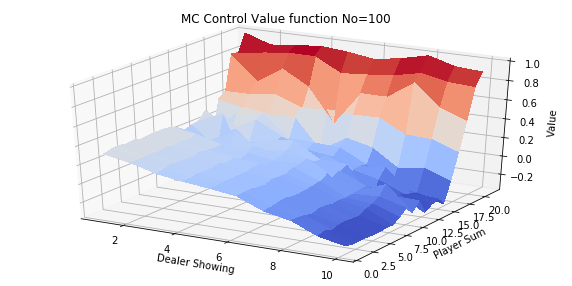

In [13]:
mc_agent = MCAgentControl(environment)
mc_agent.train(1000000)

plot_value_function(mc_agent, title="MC Control Value function No=100")

![](imgs/mcpc.gif)

In [14]:
# uncoment these lines to generate the gif you see above
# mc_agent = MCAgentControl(environment)
# plot_value_function(mc_agent, title='MC Control Value function No=100',
#                     generate_gif=True)

### 2. d) Sarsa lambda Policy Control

*Implement Sarsa(λ). Initialise the value function to zero. Use the same
step-size and exploration schedules as in the previous section.*


Sarsa is another algorithm for policy control, for the MC control algorithm we had to
finish the episode to update our value function, this is not true for Sarsa, it can do online updates.

In order to do this, instead of updating our value function accordingly with the future (return G)
we'll update it based on the next state and on a **eligibility trace**. The idea is that the
eligibility trace keeps track of how many times we've been on a state and how long has it been that
we were at that state. [A little more about it here](https://www.quora.com/Whats-your-view-on-eligibility-traces-for-temporal-difference-learning-Is-it-just-a-credit-assignment-or-speed-up-trick).

The eligibility trace is updated at every step, the algorithm to update it is below:

```
The current state is St.
    
    e_trace(St) = e_trace(St) * discount_factor * lambda + 1
    For every other state S other than St:
        e_trace(S) = e_trace(S) * discount_factor * lambda
```
![](http://cs.stanford.edu/people/karpathy/reinforcejs/img/traces.png)

The Sarsa pseudo-code is:

![](https://i.stack.imgur.com/TSr4m.png)


> FWI: there are 2 versions of sarsa, a forward view that needs a full episode in order to update the value function and a backward view (the one we'll implement!) which uses the eligibility trace. These approaches
are equivalents.


This is a more complicated algorithm so take some time to read the theory and understand why it works.

In [15]:
class SarsaAgent(Agent):
    
    def __init__(self, environment, No=100, discount_factor=1, _lambda=1):
        Agent.__init__(self, environment, No, discount_factor)
      
        # we can tune this parameter
        self._lambda = _lambda
        
        # Eligibility Trace
        self.E = self.get_clear_tensor()
        
        # Q(s, a) is the value function. How good is to choose action a being at state s?
        self.Q = self.get_clear_tensor()
        
        # N(s) is the number of times that state s has been visited
        # N(s, a) is the number of times that action a has been selected from state s.
        self.N = self.get_clear_tensor()
    
    def get_q(self, s, a):
        return self.Q[s.dealer_sum][s.agent_sum][a.value]
            
    def get_alpha(self, s, a):
        """αt = 1/N(st, at)"""
        return 1.0/(self.N[s.dealer_sum][s.agent_sum][a.value])
    
    def get_e(self, s):
        """et = N0/(N0 + N(st))"""
        return self.No/((self.No + sum(self.N[s.dealer_sum, s.agent_sum, :]) * 1.0))
    
    def get_max_action(self, s):
        return np.max(self.Q[s.dealer_sum][s.agent_sum])
    
    def choose_best_action(self, s):
        return Action.HIT if np.argmax(self.Q[s.dealer_sum][s.agent_sum]) == 1 else Action.STICK
                
    def policy(self, s):
        r = random.random()
        if r <= self.get_e(s):
            action = self.choose_random_action()
        else:
            action = self.choose_best_action(s)
            
        self.N[s.dealer_sum][s.agent_sum][action.value] += 1
        return action

    def train(self, steps):
        for e in range(steps):
            # clear eligibility trace
            self.E = self.get_clear_tensor()
            
            # get initial state for current episode
            s = self.env.initial_state()

            # choose a from s with epsilon greedy policy
            a = self.policy(s)
            next_a = a 
            
            # while game has not ended
            while not s.is_terminal:
                
                # execute action
                next_s, r = self.env.step(copy.copy(s), a)
              
                q = self.get_q(s, a)
                
                if not next_s.is_terminal:
                    # choose next action with epsilon greedy policy
                    next_a = self.policy(next_s)
                    q_next = self.get_q(next_s, next_a)
                    delta = r + (q_next - q) * self._lambda
                else:
                    delta = r - q * self._lambda
            
                self.E[s.dealer_sum][s.agent_sum][a.value] += 1
                alpha = self.get_alpha(s, a)
                update_q = alpha * delta * self.E
                self.Q += update_q
                self.E *= (self.disc_factor * self._lambda)
                
                # update state and action
                s = next_s
                a = next_a

            if e % 100000 == 0 and e != 0:
                print("Episode: %d, score: %f" % (e, (float(self.wins)/self.iterations)*100))
            
            # update wins and iterations
            self.iterations += 1
            if r == 1:
                self.wins += 1

        return self.get_value_function()

Episode: 100000, score: 50.148000
Episode: 200000, score: 50.982500
Episode: 300000, score: 51.332000
Episode: 400000, score: 51.547250
Episode: 500000, score: 51.754200
Episode: 600000, score: 51.837833
Episode: 700000, score: 51.909571
Episode: 800000, score: 51.966875
Episode: 900000, score: 51.982667


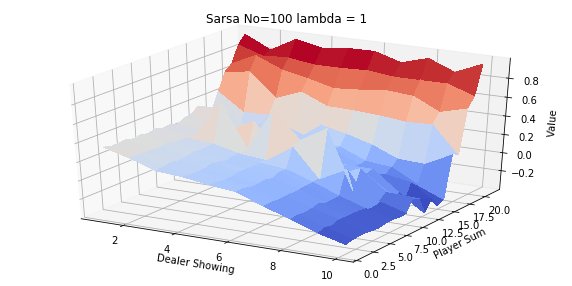

In [16]:
sarsa_agent = SarsaAgent(environment)
sarsa_agent.train(1000000)

plot_value_function(sarsa_agent, title="Sarsa No=100 lambda = 1")

![](imgs/sarsa.gif)

#### Mean Squared Error

*Run the algorithm
with parameter values λ ∈ {0, 0.1, 0.2, ..., 1}. Stop each run after 1000 episodes
2
and report the mean-squared error P
s,a(Q(s, a) − Q∗
(s, a))2 over all states s
and actions a, comparing the true values Q∗
(s, a) computed in the previous
section with the estimated values Q(s, a) computed by Sarsa. Plot the meansquared
error against λ. For λ = 0 and λ = 1 only, plot the learning curve of
mean-squared error against episode number.*

In [17]:
lambdas = [e/10.0 for e in range(0, 11, 1)]
lambdas

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [18]:
def mean_sqr(q1, q2):
    return np.sum(np.square(q1 - q2))

TRAIN_STEPS = 10000
EVAL_STEPS = 1000
errors = []
for i, l in enumerate(lambdas):
    print('Training Sarsa(%.1f)' % l)
    errors.append([])
    sarsa_agent = SarsaAgent(environment, _lambda=l)
    for j in range(TRAIN_STEPS//EVAL_STEPS):
        sarsa_agent.train(EVAL_STEPS)
        errors[i].append(mean_sqr(mc_agent.Q, sarsa_agent.Q))

Training Sarsa(0.0)
Training Sarsa(0.1)
Training Sarsa(0.2)
Training Sarsa(0.3)
Training Sarsa(0.4)
Training Sarsa(0.5)
Training Sarsa(0.6)
Training Sarsa(0.7)
Training Sarsa(0.8)
Training Sarsa(0.9)
Training Sarsa(1.0)


/home/marianne/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


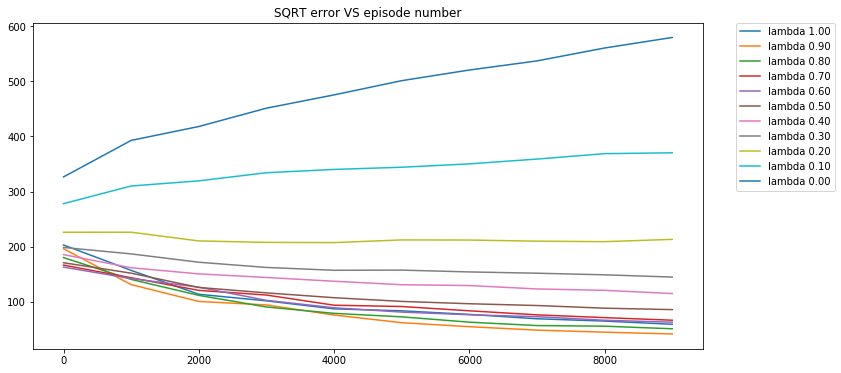

In [19]:
plot_error_vs_episode(errors, lambdas, train_steps=TRAIN_STEPS, eval_steps=EVAL_STEPS)

![](imgs/sqrt_error_vs_steps_sarsa.png)

No handles with labels found to put in legend.


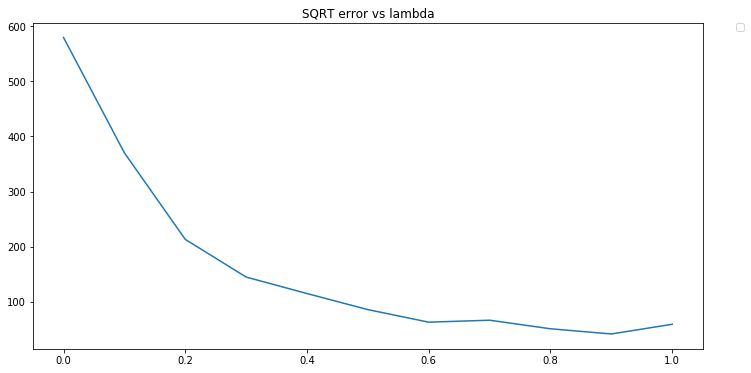

In [20]:
plot_error_vs_lambda(errors, lambdas)

![](imgs/sqrt_error_vs_lambda_sarsa.png)

### 2. e) Linear Function approximation

Sometimes the number of states and actions is too big, and using a matrix or tensor to represent all these states and actions is not a scalable solution and maybe not even possible. Fortunatelly there's an easy solution, we can use a value function approximator that can represent a state and action as a low-dim vector, this approximator can be a linear regression, neural network, conv net,...

For this exercise we'll use a simple linear approximator, since the update is very simple:
    Update = step-size × prediction error × feature value
    
And now our value function will be given by: phi(s, a) * theta, where phi(s, a) is a approximate representation of this state and theta is our tensor of parameters that we'll actually update.

We now consider a simple value function approximator using coarse coding. Use a binary feature vector φ(s, a) with 3 x 6 x 2 = 36 features. Each binary feature
has a value of 1 iff (s, a) lies within the cuboid of state-space corresponding to
that feature, and the action corresponding to that feature. The cuboids have
the following overlapping intervals:
dealer(s) = {[1, 4], [4, 7], [7, 10]}
player(s) = {[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]}
a = {hit, stick}
where
• dealer(s) is the value of the dealer’s first card (1–10)
• sum(s) is the sum of the player’s cards (1–21)
Repeat the Sarsa(λ) experiment from the previous section, but using linear
value function approximation Q(s, a) = φ(s, a)
>θ. Use a constant exploration
of e = 0.05 and a constant step-size of 0.01. Plot the mean-squared error against
λ. For λ = 0 and λ = 1 only, plot the learning curve of mean-squared error
against episode number.*

In [21]:
class LinearFunctionSarsaAgent(Agent):
    
    def __init__(self, environment, No=100, discount_factor=1, _lambda=1):    
        Agent.__init__(self, environment, No, discount_factor)
        
        # we can tune these parameters
        self._lambda = _lambda
        self.number_of_parameters = 36
        
        # parameters are initialize randomly
        self.theta = np.random.randn(self.number_of_parameters) * 0.1
        
        # eligibility trace
        self.E = self.get_clear_tensor()
  
        # features
        self.dealer_features = [[1, 4], [4, 7], [7, 10]]
        self.agent_features = [[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]]
    
    def get_clear_tensor(self):
        """Returns a tensor with zeros with the correct shape."""
        return np.zeros(self.number_of_parameters)

    def get_q(self, s, a):
        return np.dot(self.phi(s, a), self.theta)
    
    def get_all_q(self):
        q = np.zeros((self.env.dealer_max_value + 1,
                         self.env.agent_max_value + 1, 
                         self.env.actions_count))
        
        for i in range(1, self.env.dealer_max_value + 1):
            for j in range(1, self.env.agent_max_value + 1):
                for a in [Action.HIT, Action.STICK]:
                    s = State(i, j)
                    q[i, j, a.value] = self.get_q(s, a)
    
        return q

    def phi(self, s, a):
        d_sum = s.dealer_sum
        a_sum = s.agent_sum
        
        features = np.zeros((3, 6, 2), dtype=np.int)
        
        d_features = np.array([x[0] <= d_sum <= x[1] for x in self.dealer_features])
        a_features = np.array([x[0] <= a_sum <= x[1] for x in self.agent_features])
        
        for i in np.where(d_features):
            for j in np.where(a_features):
                features[i, j, a.value] = 1

        return features.flatten()
   
    def get_alpha(self, s, a):
        return 0.01
       
    def get_e(self, s):
        return 0.05

    def try_all_actions(self, s):
        return [np.dot(self.phi(s, Action.STICK), self.theta), np.dot(self.phi(s, Action.HIT), self.theta)]
    
    def get_max_action(self, s):
        return np.max(self.try_all_actions(s))
    
    def choose_best_action(self, s):
        return Action.HIT if np.argmax(self.try_all_actions(s)) == 1 else Action.STICK
    
    def policy(self, s):
        r = random.random()
        if r <= self.get_e(s):
            action = self.choose_random_action()
        else:
            action = self.choose_best_action(s)

        return action

    def train(self, steps):
        for e in range(steps):
            # clear eligibility trace
            self.E = self.get_clear_tensor()
            
            # get initial state for current episode
            s = self.env.initial_state()

            # choose a from s with epsilon greedy policy
            a = self.policy(s)
            next_a = a 
                 
            # while game has not ended
            while not s.is_terminal:
                
                # execute action
                next_s, r = self.env.step(copy.copy(s), a)
              
                # get parameters that represent this state and action
                phi = self.phi(s, a)
                # get q(s, a)
                q = self.get_q(s, a)
                
                if not next_s.is_terminal:
                    # choose next action with epsilon greedy policy
                    next_a = self.policy(next_s)
                    q_next = self.get_q(next_s, next_a)
                    delta = r + q_next - q
                else:
                    delta = r - q 
            
                self.E += phi
                alpha = self.get_alpha(s, a)
                update_q = alpha * delta * self.E
                self.theta += update_q
                self.E *= (self.disc_factor * self._lambda)
                
                # update state and action
                s = next_s
                a = next_a

            if e % 10000 == 0 and e != 0:
                print("Episode: %d, score: %f" % (e, (float(self.wins)/self.iterations)*100))
            
            # update wins and iterations
            self.iterations += 1
            if r == 1:
                self.wins += 1

        return self.get_value_function()

gif will be saved as Linear Function Sarsa No=100 lambda = 1
Episode: 10000, score: 51.671468
Episode: 10000, score: 51.828470
Episode: 20000, score: 51.931095
Episode: 30000, score: 51.927734
Episode: 10000, score: 51.989780
Episode: 20000, score: 52.110223
Episode: 30000, score: 52.098685
Episode: 40000, score: 52.067541
Episode: 50000, score: 52.052174
Episode: 60000, score: 51.938089
Episode: 10000, score: 51.945815
Episode: 20000, score: 51.946754
Episode: 30000, score: 51.922743
Episode: 40000, score: 51.892770
Episode: 50000, score: 51.921335
Episode: 60000, score: 51.956854
Episode: 10000, score: 52.009119
Episode: 20000, score: 52.004543
Episode: 30000, score: 52.015816
Episode: 40000, score: 52.033321
Episode: 50000, score: 52.022238
Episode: 60000, score: 52.032283
Episode: 10000, score: 52.032380
Episode: 20000, score: 52.084397
Episode: 30000, score: 52.091092
Episode: 40000, score: 52.101316
Episode: 50000, score: 52.093265
Episode: 60000, score: 52.095026
Episode: 10000,

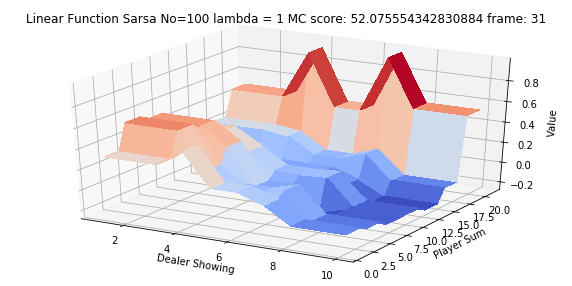

In [22]:
sarsa_agent = LinearFunctionSarsaAgent(environment)
# sarsa_agent.train(1000000)

plot_value_function(sarsa_agent, title="Linear Function Sarsa No=100 lambda = 1", generate_gif=True)

![](imgs/linear_function_sarsa.gif)

**Mean Squared Error**

In [23]:
def mean_sqr(q1, q2):
    return np.sum(np.square(q1 - q2))

EVAL_STEPS = 1000
TRAIN_STEPS = 100000
errors = []
for i, l in enumerate(lambdas):
    print('Training Sarsa(%f)' % l)
    errors.append([])
    sarsa_agent = LinearFunctionSarsaAgent(environment, _lambda=l)
    for j in range(TRAIN_STEPS//EVAL_STEPS):
        sarsa_agent.train(TRAIN_STEPS//EVAL_STEPS)
        errors[i].append(mean_sqr(mc_agent.Q, sarsa_agent.get_all_q()))

Training Sarsa(0.000000)
Training Sarsa(0.100000)
Training Sarsa(0.200000)
Training Sarsa(0.300000)
Training Sarsa(0.400000)
Training Sarsa(0.500000)
Training Sarsa(0.600000)
Training Sarsa(0.700000)
Training Sarsa(0.800000)
Training Sarsa(0.900000)
Training Sarsa(1.000000)


/home/marianne/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


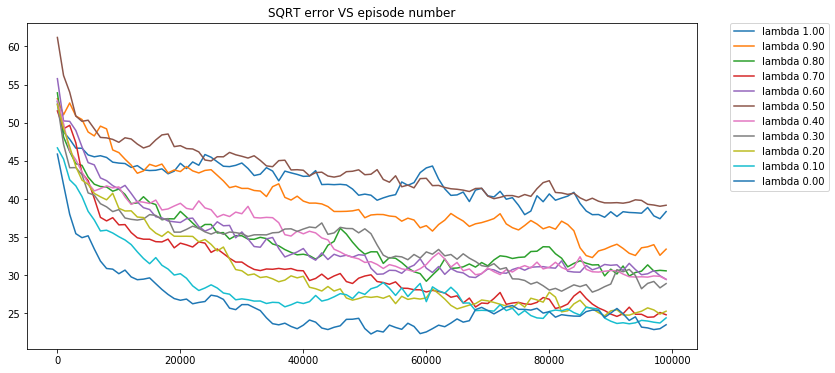

In [24]:
plot_error_vs_episode(errors, lambdas, train_steps=TRAIN_STEPS, eval_steps=EVAL_STEPS)

![](imgs/sqrt_error_vs_steps_linear.png)

No handles with labels found to put in legend.


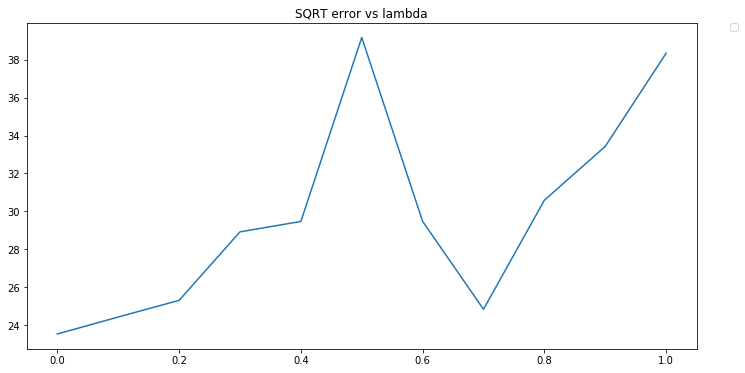

In [25]:
plot_error_vs_lambda(errors, lambdas)

![](imgs/sqrt_error_vs_lamba_linear.png)

## 3. What's next?

* [RL Course by David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html)
* [How do I learn reinforcement learning?](https://www.quora.com/How-do-I-learn-reinforcement-learning)
* [CS234: Reinforcement Learning](http://web.stanford.edu/class/cs234/index.html)
* [Open AI gym](https://gym.openai.com/envs)
* [Denny Britz RL github repository](https://github.com/dennybritz/reinforcement-learning)
* [Karpathy's tips on his blog post](http://karpathy.github.io/2016/05/31/rl/).